<h1>TensorFlow Introduction</h1>

graph = list of partial computations 

session = computing part of or the entire graph

In [47]:
import numpy as np
import tensorflow as tf

## Making Tensors

The following examples have degree 0

In [48]:
sentence = tf.Variable("Heavy lies the head that wears the crown", tf.string)
num = tf.Variable(2023, tf.int16)
floatingPointNum = tf.Variable(0.69134)

## Rank and Degree of Tensors

In [49]:
rank1_tensor = tf.Variable(["test", "hi", "sumanth"], tf.string)
rank2_tensor = tf.Variable([['1', '2', '5'],['3', '4', '6']], tf.string)

To find the rank/degree of a tensor we use:


In [50]:
tf.rank(rank1_tensor)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

## Tensor Shape

Tells us the number of elements in each dimension



In [51]:
rank2_tensor.shape #would return TensorShape([2, 3]) because there are 2 subarrays and each subarray contains 3 elements

TensorShape([2, 3])

## Changing Shape

Change the way elements are organized by making different shapes

In [52]:
tensor1 = tf.ones([1,2,3]) #makes a list containing 1s w/ the given shape
tensor2 = tf.reshape(tensor1, [2,3,1])
tensor3 = tf.reshape(tensor1, [3, -1]) #passing in -1 makes the program infer what the length should be. The product of the values of the shape array equals the number of elements in the list.

In [53]:
print(tensor1)
print(tensor2)
print(tensor3)

tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]]], shape=(1, 2, 3), dtype=float32)
tf.Tensor(
[[[1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]]], shape=(2, 3, 1), dtype=float32)
tf.Tensor(
[[1. 1.]
 [1. 1.]
 [1. 1.]], shape=(3, 2), dtype=float32)


In [54]:
t = tf.ones([6,2,4])
print(t)
t = tf.reshape(t, 48)

tf.Tensor(
[[[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]], shape=(6, 2, 4), dtype=float32)


# TensorFlow Core Learning Algorithms

* Linear Regression
* Classification

Imports:

In [55]:
from __future__ import absolute_import, division, print_function, unicode_literals # must be at the beginning of the file

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc # feature column used in linear regression model
import tensorflow as tf



Reading the files:

In [56]:
dftrain = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
dfeval = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')
print(dftrain.loc[0], y_train.loc[0])

sex                          male
age                          22.0
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object 0


Ways of representing data:

In [57]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [58]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


We can look at shape too:

In [59]:
dftrain.shape #(627, 9) means 627 rows and 9 columns (attributes)

(627, 9)

## Drawing plots 
### This gives us a sense for what the data looks like.

<AxesSubplot: >

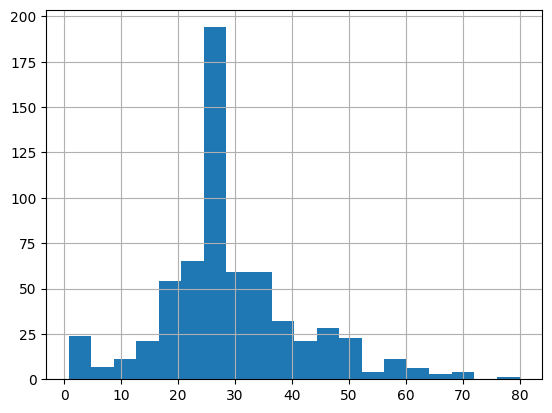

In [60]:
dftrain.age.hist(bins=20)

The graph above shows that most people are from 20-30 years old. We can also look at gender: 

<AxesSubplot: >

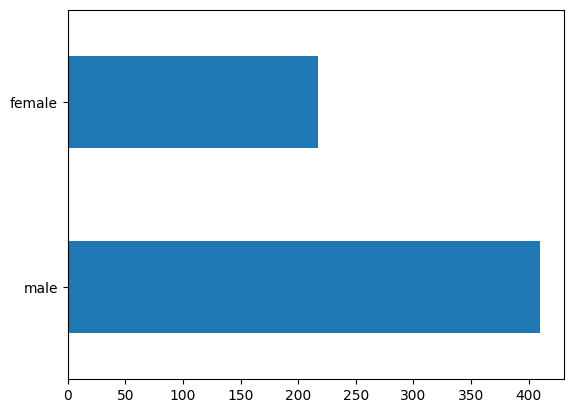

In [61]:
dftrain.sex.value_counts().plot(kind='barh')

<AxesSubplot: >

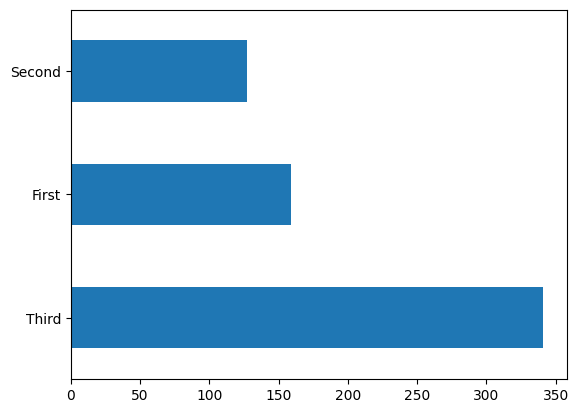

In [62]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

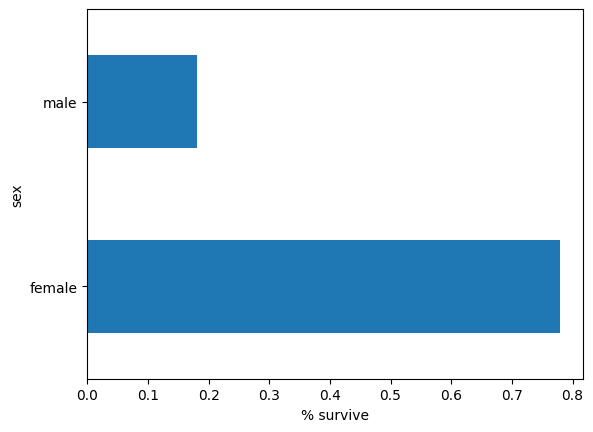

In [63]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel(r'% survive')

Now a quick look at how big the testing dataset is:

In [64]:
dfeval.shape

(264, 9)

To prepare the data for the ML model, we transform all the categorical data (e.g. sex - "male", "female") into numerical data.

In [65]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique() # gets all the unique values from the given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)) 

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns) 

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

### Training Process

* Data is fed into the model in **batches** (here we do 32 at a time)
* Model is trained in **epochs** (an epoch defines how often the model looks at the training data - e.g. one epoch means the model looks at the training data once; in each epoch it looks at the data in a different way)
* We need an input function to convert the data into batches.

For the input function, we need to convert to a `tf.data.Dataset` object, so we need to turn our CategoricalColumn (a pandas dataframe) into that type in order to use the TensorFlow model.

In [66]:
# def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
#     def input_function(): #inner function which will be returned
#         ds = tf.data.Dataset.from_tensor_slices(dict(data_df), label_df) # makes tf.data.Dataset object with data and its labels
#         if shuffle:
#             ds = ds.shuffle(1000) # randomize order of data
#         ds = ds.batch(batch_size).repeat(num_epochs) # split dataset into batches of 32 and repeat process for number of epochs
#         return ds
#     return input_function # return a function object for use

def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function(): 
        data_tensor = {key:np.array(value) for key,value in dict(data_df).items()}
        label_tensor = np.array(label_df)
        ds = tf.data.Dataset.from_tensor_slices((data_tensor, label_tensor))
        if shuffle:
            ds = ds.shuffle(1000) 
        ds = ds.batch(batch_size).repeat(num_epochs) 
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train) # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

To utilize a linear regression algorithm we use TF estimators (all the core learning algorithms use this):

In [67]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns) # We create a linear estimtor by passing the feature columns we created earlier 

linear_est.train(train_input_fn) # train
result = linear_est.evaluate(eval_input_fn) # get model metrics/stats by testing on tetsing data

clear_output() # clears console output
print(f"Accuracy: {result}") # the result variable is simply a dict of stats about our model

Accuracy: {'accuracy': 0.7613636, 'accuracy_baseline': 0.625, 'auc': 0.82402813, 'auc_precision_recall': 0.7728793, 'average_loss': 0.517689, 'label/mean': 0.375, 'loss': 0.50745004, 'precision': 0.725, 'prediction/mean': 0.29060388, 'recall': 0.5858586, 'global_step': 200}


## Making the Falling ML Model


In [70]:
import csv

In [68]:
# put all falling data into CSV file

with open(r'arduino-data\falling\FallOnBedArduino.TXT', 'r') as f:
    lines = f.readlines()

def write_text_to_csv(fileName):
    with open(fileName, 'r') as f:
        markers = []
        lines = f.readlines()
        print(lines)
        counter = 0
        for line in lines:
            if line == "New Trial\n":
                markers.append(counter)
            counter += 1
        # print(markers)
    
    for marker in markers[:-1]:
        print(marker)


    with open('ML_data\FallOnBedArduino.csv', 'w', newline='') as f:
        writer = csv.writer(f)

    

write_text_to_csv(r'arduino-data\falling\Venkat_falling_5_9_23.TXT')


['New Trial\n', '\n', ' + New event: \n', '896\n', '-0.49\n', '8.75\n', '3.75\n', '0.04\n', '0.02\n', '0.00\n', '\n', ' + New event: \n', '902\n', '-0.48\n', '8.73\n', '3.74\n', '0.04\n', '0.02\n', '0.00\n', '\n', ' + New event: \n', '908\n', '-0.48\n', '8.74\n', '3.74\n', '0.05\n', '0.02\n', '0.00\n', '\n', ' + New event: \n', '913\n', '-0.50\n', '8.77\n', '3.71\n', '0.04\n', '0.02\n', '-0.00\n', '\n', ' + New event: \n', '919\n', '-0.52\n', '8.77\n', '3.69\n', '0.04\n', '0.02\n', '-0.00\n', '\n', ' + New event: \n', '925\n', '-0.55\n', '8.77\n', '3.68\n', '0.04\n', '0.02\n', '-0.01\n', '\n', ' + New event: \n', '930\n', '-0.58\n', '8.76\n', '3.67\n', '0.04\n', '0.02\n', '-0.01\n', '\n', ' + New event: \n', '936\n', '-0.62\n', '8.75\n', '3.67\n', '0.04\n', '0.02\n', '-0.01\n', '\n', ' + New event: \n', '943\n', '-0.66\n', '8.77\n', '3.67\n', '0.04\n', '0.02\n', '-0.01\n', '\n', ' + New event: \n', '953\n', '-0.73\n', '8.75\n', '3.61\n', '0.04\n', '0.02\n', '-0.01\n', '\n', ' + New eve